In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
import pennylane as qml
from pennylane import numpy
from scipy.optimize import minimize
import csv


/var/folders/72/24j7jy9s6sb2xm_dc84kdhm00000gn/T/ipykernel_45264/2163458919.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/edoardozappia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_csv('/Users/edoardozappia/Downloads/creditcard.csv')

In [3]:
print(len(df['Amount']))

284807


In [4]:
df['V29']=np.zeros((len(df['Amount']), 1))
df['V30']=np.zeros((len(df['Amount']), 1))
df['V31']=np.zeros((len(df['Amount']), 1))

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,V29,V30,V31
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,0.0,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,0.0,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,0.0,0.0


In [6]:
df['Amount'] = np.log10(df.Amount + 0.00001)

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,V29,V30,V31
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,2.174990,0,0.0,0.0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.429754,0,0.0,0.0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,2.578249,0,0.0,0.0,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,2.091667,0,0.0,0.0,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.141267,-0.206010,0.502292,0.219422,0.215153,1.845036,0,0.0,0.0,0.0


In [8]:
# Split
fraud = df[df['Class'] == 1]
clean = df[df['Class'] == 0]

In [9]:
# Shuffle
clean = clean.sample(frac=1).reset_index(drop=True)

In [10]:
# training set: exlusively non-fraud transactions
X_train = clean.iloc[:50].drop('Class', axis=1)

In [11]:
print(len(X_train['V1']))

50


In [12]:
# testing  set: the remaining non-fraud + all the fraud 
fraud_test = fraud[:20]

# Concatenazione dei dati non fraudolenti e fraudolenti
X_test = pd.concat([clean.iloc[50:80], fraud_test]).sample(frac=1).reset_index(drop=True)

X_test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,V29,V30,V31
0,29190.0,1.178779,0.289131,0.404809,1.215202,-0.470039,-1.151564,0.240361,-0.248064,-0.010665,...,0.719485,0.628944,-0.350275,0.008653,0.027047,1.420286,0,0.0,0.0,0.0
1,7526.0,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,...,0.128940,1.488481,0.507963,0.735822,0.513574,0.000004,1,0.0,0.0,0.0
2,161926.0,2.139731,-1.073674,-0.470832,-1.019590,-1.088445,-0.232732,-1.246465,0.086816,-0.029891,...,-0.441089,-0.209925,-0.053942,0.012290,-0.060592,1.000000,0,0.0,0.0,0.0
3,73090.0,-2.029975,-0.165998,2.240715,2.659206,1.061326,-0.639997,0.424318,0.016855,-1.549237,...,0.597560,0.428419,0.092096,0.110160,-0.033600,1.342423,0,0.0,0.0,0.0
4,45533.0,-0.941115,0.729011,1.642943,-1.421134,-0.245224,-0.474474,0.288536,0.343846,0.185691,...,0.202226,-0.485694,0.729542,0.361311,0.225955,-0.508624,0,0.0,0.0,0.0


In [13]:
print(f"""Our testing set is composed as follows:

{X_test.Class.value_counts()}""")

Our testing set is composed as follows:

Class
0    30
1    20
Name: count, dtype: int64


In [14]:
# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [15]:
# get normalization parameters by fitting to the training data
pipeline.fit(X_train);

In [16]:
# transform the training and validation data with these parameters
X_train_transformed = pipeline.transform(X_train)
print(X_train_transformed)

[[0.96220754 0.80565581 0.44909805 ... 0.         0.         0.        ]
 [0.99874694 0.87387156 0.33060225 ... 0.         0.         0.        ]
 [0.99288813 0.87566165 0.32152978 ... 0.         0.         0.        ]
 ...
 [0.99504528 0.88173145 0.35618405 ... 0.         0.         0.        ]
 [0.99388271 0.89151231 0.33657265 ... 0.         0.         0.        ]
 [0.95193886 0.91577269 0.41856452 ... 0.         0.         0.        ]]


In [17]:
def ansatz_custom_digits(params, n_wires_latent, n_wires_trash):
    params = qml.numpy.tensor(params, requires_grad=True)
    for j in range(6):
        for i in range(n_wires_latent+n_wires_trash):
            k = j*5+i
            qml.RY(params[k], wires=i)
        if j!=4:
            for i in range(n_wires_latent + n_wires_trash - 1):
                qml.CNOT(wires=[i, i+1])

In [18]:
dev = qml.device('default.qubit', wires=8)
@qml.qnode(dev)
def train_circuit(params, image):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4, 5, 6])
    ansatz_custom_digits(image, n_wires_latent, n_wires_trash)
    ansatz_custom_digits(params, n_wires_latent, n_wires_trash)
    swap_test(n_wires_latent, n_wires_trash)
    return qml.probs(wires=7)

In [19]:
def swap_test(num_latent, num_trash):
    auxiliary_qubit = num_latent + 2 * num_trash
    qml.Hadamard(auxiliary_qubit)
    for i in range(num_trash):
        qml.CSWAP(wires=[auxiliary_qubit, num_latent + i, num_latent + num_trash + i])
    qml.Hadamard(auxiliary_qubit)

In [20]:
n_wires_latent = 3
n_wires_trash = 2
n_wires_total = n_wires_latent + 2 * n_wires_trash +1

In [21]:
params = np.random.random((30,))
params = qml.numpy.tensor(params, requires_grad=True)

(<Figure size 4000x900 with 1 Axes>, <Axes: >)


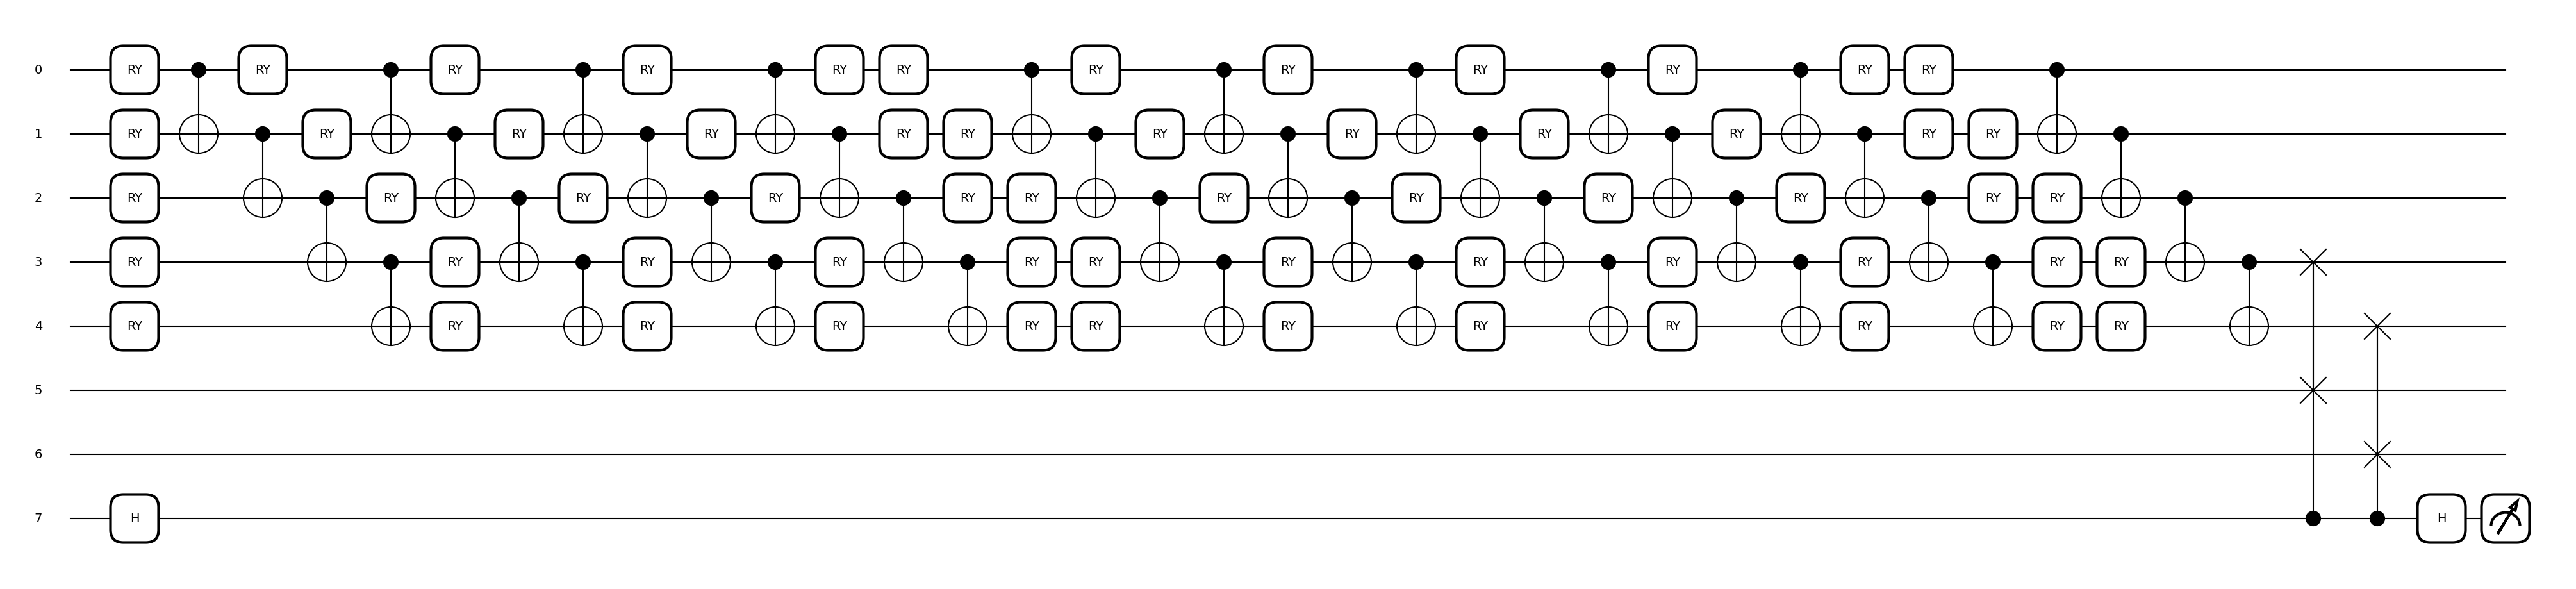

In [22]:
drawer = qml.draw_mpl(train_circuit)
print(drawer(params, X_train_transformed[0]))

In [23]:
def cost_function(weights):
    probabilities = [train_circuit(weights, transaction) for transaction in X_train_transformed]
    print(probabilities)
    cost_value = np.sum([p[1] for p in probabilities])/X_train_transformed.shape[0]
    return cost_value

In [24]:
cost_values = []
opt_weights = []
def callback(xk):
    cost_val = cost_function(xk)
    cost_values.append(cost_val)
    opt_weights.append(xk)
    print(f"Step {len(cost_values)}: cost = {cost_val:.4f}, params = {xk}")

In [25]:
minimize(cost_function, params, method='COBYLA', callback=callback, options={'maxiter': 300})
opt_weights = opt_weights[-1]

[tensor([0.63501816, 0.36498184], requires_grad=True), tensor([0.63246447, 0.36753553], requires_grad=True), tensor([0.63275694, 0.36724306], requires_grad=True), tensor([0.64258492, 0.35741508], requires_grad=True), tensor([0.6698326, 0.3301674], requires_grad=True), tensor([0.56148287, 0.43851713], requires_grad=True), tensor([0.6211102, 0.3788898], requires_grad=True), tensor([0.62956632, 0.37043368], requires_grad=True), tensor([0.56756548, 0.43243452], requires_grad=True), tensor([0.62064173, 0.37935827], requires_grad=True), tensor([0.63867658, 0.36132342], requires_grad=True), tensor([0.61077166, 0.38922834], requires_grad=True), tensor([0.59504931, 0.40495069], requires_grad=True), tensor([0.62144265, 0.37855735], requires_grad=True), tensor([0.59319091, 0.40680909], requires_grad=True), tensor([0.60049497, 0.39950503], requires_grad=True), tensor([0.73894796, 0.26105204], requires_grad=True), tensor([0.59252144, 0.40747856], requires_grad=True), tensor([0.66636812, 0.33363188]

In [26]:
# Salva i pesi ottimizzati in un file CSV
with open("optimized_weights_quantum_anomaly_det.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Peso"])
    writer.writerows([[weight] for weight in opt_weights])

In [27]:
print(cost_values[-1])

0.06930363324299227


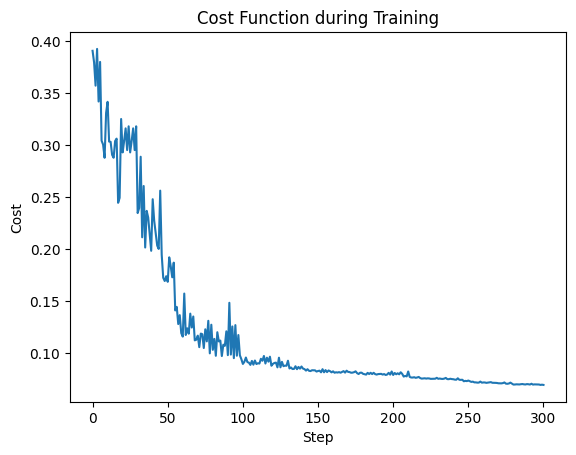

In [28]:
# Traccia la funzione di perdita durante l'addestramento
plt.plot(cost_values)
plt.xlabel('Step')
plt.ylabel('Cost')
plt.title('Cost Function during Training')
plt.show()

In [29]:
# Reset the qubits indicated by wir to zero
def reset_to_zero(wir):
    m1 = qml.measure(wir[0])
    m2 = qml.measure(wir[1])
    qml.cond(m1, qml.PauliX)(wir[0])
    qml.cond(m2, qml.PauliX)(wir[1])

In [30]:
@qml.qnode(dev)
def autoencoder(opt_weights, transaction):
    qml.devices.qubit.create_initial_state([0, 1, 2, 3, 4])
    ansatz_custom_digits(transaction, n_wires_latent, n_wires_trash)
    ansatz_custom_digits(opt_weights, n_wires_latent, n_wires_trash)
    reset_to_zero([3, 4])
    qml.adjoint(ansatz_custom_digits)(opt_weights, n_wires_latent, n_wires_trash)
    #return [qml.expval(qml.PauliZ(i)) for i in range(5)]
    return qml.density_matrix(wires=[0, 1, 2, 3, 4])

(<Figure size 5900x700 with 1 Axes>, <Axes: >)


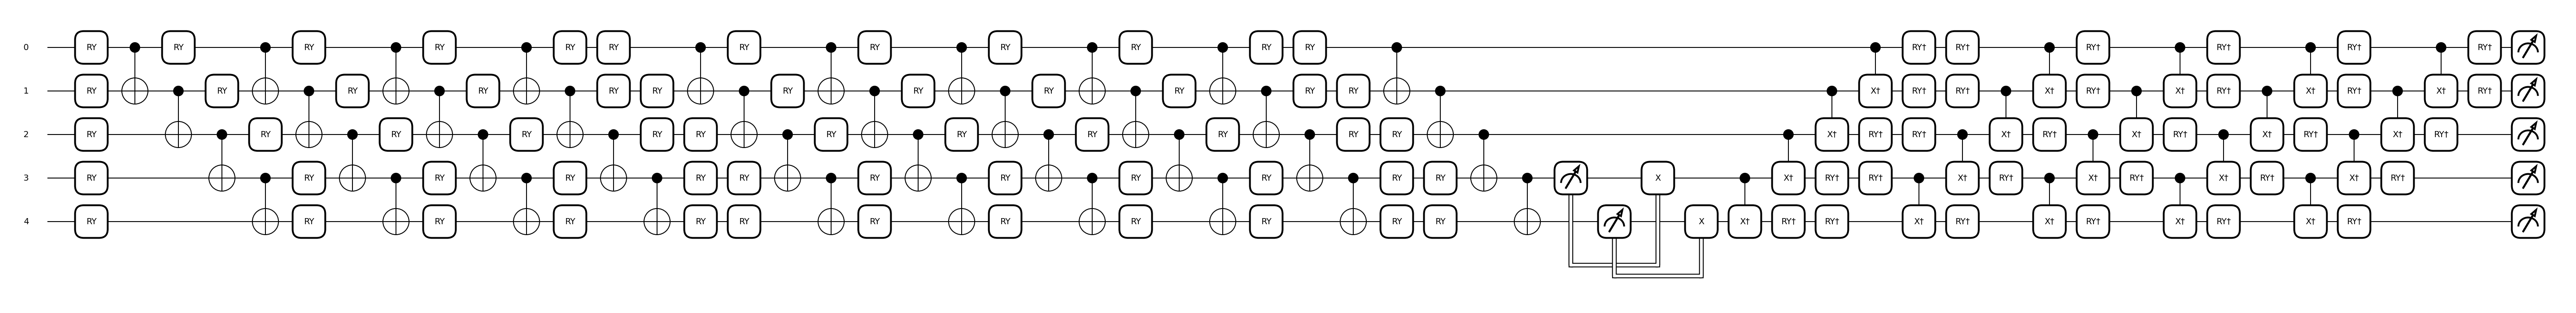

In [31]:
drawer_2 = qml.draw_mpl(autoencoder)
print(drawer_2(opt_weights, X_train_transformed[0]))